In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow.keras.backend as K

sns.set(style='ticks', palette='Set2')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [17]:
import sys 
!{sys.executable} -m pip install missingno

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import missingno as msno

## Import Sequence Data

In [2]:
splice_data = pd.read_csv("splice.csv", skipinitialspace=True)

In [3]:
splice_data.head()

,Class,Donor,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


## Exploratory Data Analysis

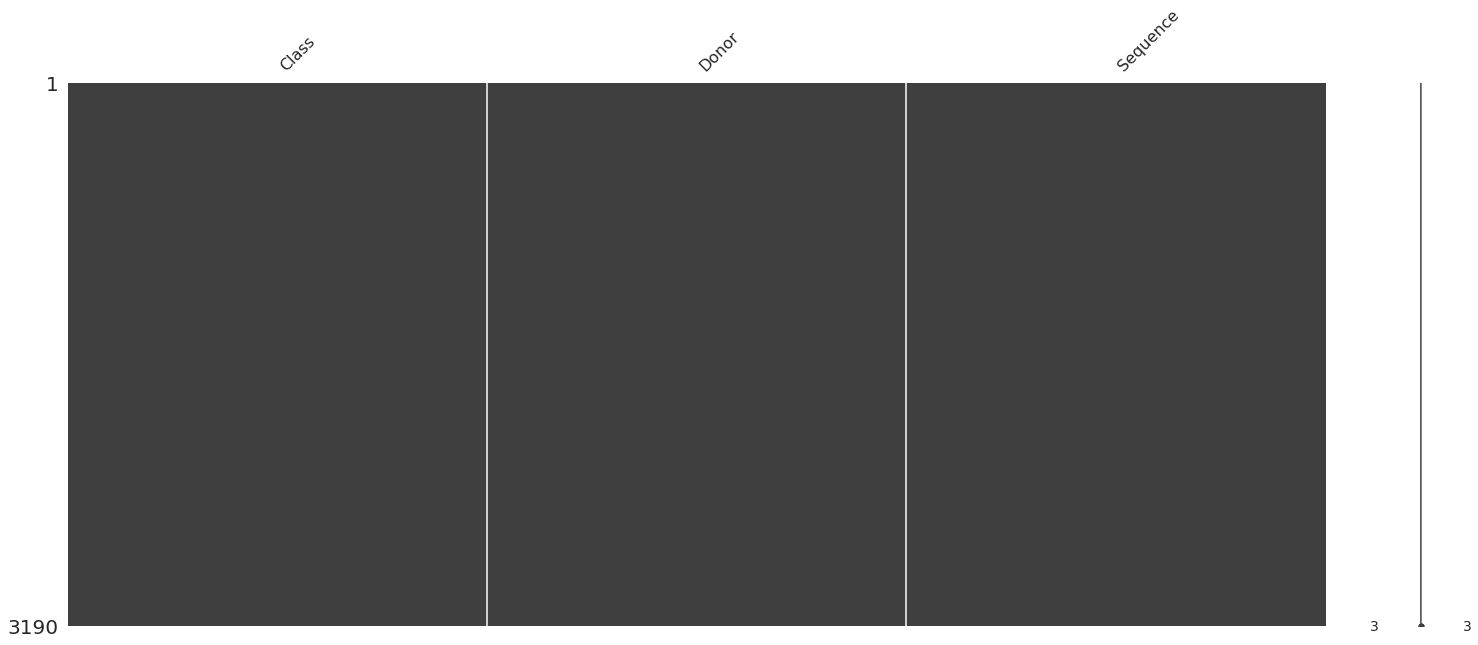

In [9]:
msno.matrix(splice_data)

In [39]:
def get_kmer_counts(sequence_list, size, num_largest):
    cv = CountVectorizer(analyzer='char', ngram_range=(size, size))   
    cv_fit = cv.fit_transform(sequence_list)    
    word_list = cv.get_feature_names();    
    count_list = cv_fit.toarray().sum(axis=0)  
    
    kmer_df = pd.DataFrame(data={'K-mer': [seq.upper() for seq in word_list], 'Count': count_list})
    
    return kmer_df.nlargest(num_largest, 'Count')

In [40]:
base_counts_EI = get_kmer_counts(splice_data[splice_data['Class'] == 'EI']['Sequence'], 1, 10)
base_counts_IE = get_kmer_counts(splice_data[splice_data['Class'] == 'IE']['Sequence'], 1, 10)
base_counts_N = get_kmer_counts(splice_data[splice_data['Class'] == 'N']['Sequence'], 1, 10)

Text(0, 0.5, 'Frequency')

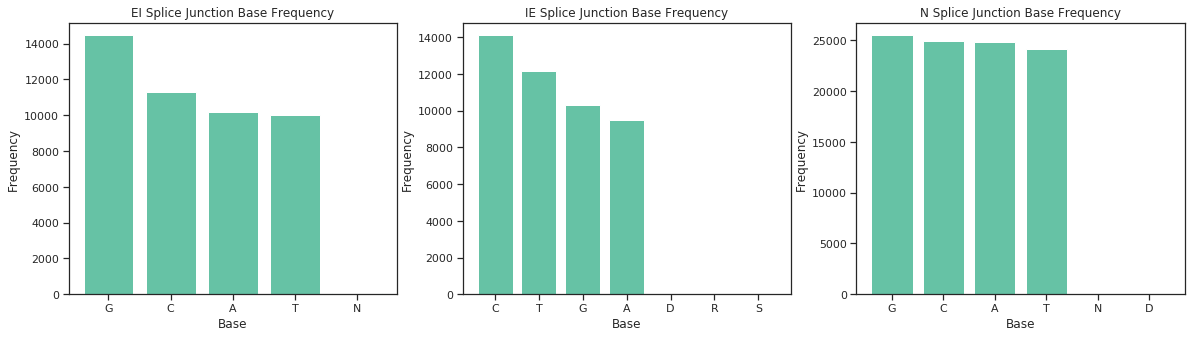

In [41]:
fig = plt.figure(figsize=(20,5))

ax1 = plt.subplot(1, 3, 1)
plt.bar(base_counts_EI['K-mer'], base_counts_EI['Count'])
plt.xlabel('Base')
ax1.set_title('EI Splice Junction Base Frequency')
plt.ylabel('Frequency')

ax2 = plt.subplot(1, 3, 2)
plt.bar(base_counts_IE['K-mer'], base_counts_IE['Count'])
plt.xlabel('Base')
ax2.set_title('IE Splice Junction Base Frequency')
plt.ylabel('Frequency')


ax3 = plt.subplot(1, 3, 3)
plt.bar(base_counts_N['K-mer'], base_counts_N['Count'])
plt.xlabel('Base')
ax3.set_title('N Splice Junction Base Frequency')
plt.ylabel('Frequency')

In [14]:
kmer_counts_EI = get_kmer_counts(splice_data[splice_data['Class'] == 'EI']['Sequence'], 6, 10)
kmer_counts_IE = get_kmer_counts(splice_data[splice_data['Class'] == 'IE']['Sequence'], 6, 10)
kmer_counts_N = get_kmer_counts(splice_data[splice_data['Class'] == 'N']['Sequence'], 6, 10)

Text(0, 0.5, 'Frequency')

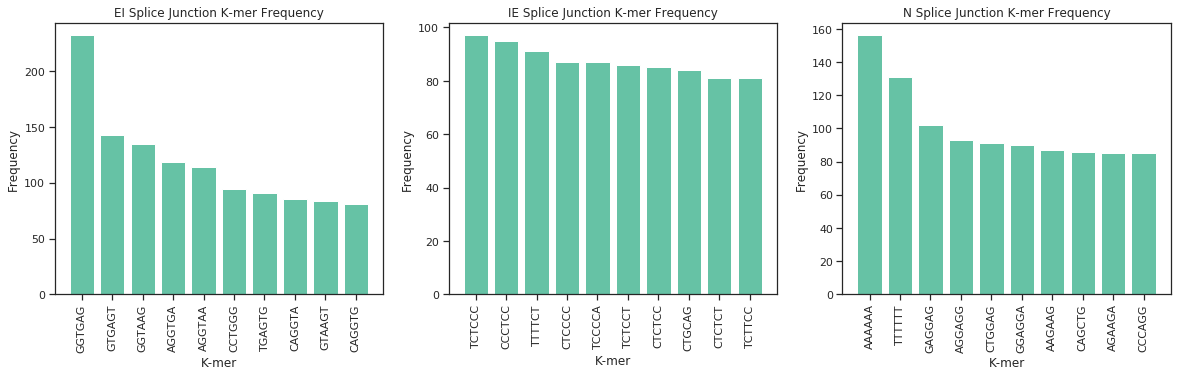

In [15]:
fig = plt.figure(figsize=(20,5))

ax1 = plt.subplot(1, 3, 1)
plt.bar(kmer_counts_EI['K-mer'], kmer_counts_EI['Count'])
plt.xlabel('K-mer')
plt.xticks(rotation='vertical')
ax1.set_title('EI Splice Junction K-mer Frequency')
plt.ylabel('Frequency')

ax2 = plt.subplot(1, 3, 2)
plt.bar(kmer_counts_IE['K-mer'], kmer_counts_IE['Count'])
plt.xlabel('K-mer')
plt.xticks(rotation='vertical')
ax2.set_title('IE Splice Junction K-mer Frequency')
plt.ylabel('Frequency')


ax3 = plt.subplot(1, 3, 3)
plt.bar(kmer_counts_N['K-mer'], kmer_counts_N['Count'])
plt.xlabel('K-mer')
plt.xticks(rotation='vertical')
ax3.set_title('N Splice Junction K-mer Frequency')
plt.ylabel('Frequency')

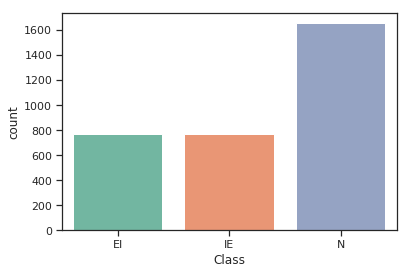

In [16]:
sns.countplot(x='Class', data=splice_data)

## Prepare Sequence Data For Machine Learning

In [6]:
base_map = {'A':0, 'C':1, 'G':2, 'T':3, 'N':4, 'D':5, 'R':6, 'S':7}
featurized_seq_list = []

one_hot_encoder = OneHotEncoder(n_values=len(base_map))

for sequence in splice_data['Sequence']:
    seq_list = np.array([base_map[base] for base in list(sequence)])
    seq_list = seq_list.reshape(-1,1)
    one_hot_encode = one_hot_encoder.fit_transform(seq_list)
    featurized_seq_list.append(one_hot_encode.toarray())

np.set_printoptions(threshold=40)
featurized_seq_list = np.stack(featurized_seq_list)
print('First Sequence:\n')
print(splice_data['Sequence'][0])
print('One Hot Encoded Sequence:\n')
print(featurized_seq_list[0])

First Sequence:

CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCCTTCGAGCCAGTCTG
One Hot Encoded Sequence:

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [7]:
one_hot_encoder = OneHotEncoder(categories='auto')
splice_classes = np.array(splice_data['Class']).reshape(-1,1)
input_labels = one_hot_encoder.fit_transform(splice_classes).toarray()

print('Labels:\n',splice_classes[0])
print('One-hot encoded labels:\n',input_labels[0])

Labels:
 ['EI']
One-hot encoded labels:
 [1. 0. 0.]


In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(featurized_seq_list, input_labels, random_state=42)

In [16]:
'''model = Sequential()
model.add(Conv1D(filters=8, kernel_size=10, 
                 input_shape=(train_features.shape[1], 8))) 
model.add(Flatten())
model.add(Dense(70, activation='relu')) 
model.add(Dropout(rate=0.2)) 
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4),
              metrics=['categorical_accuracy'])
model.summary()'''

model = Sequential()
model.add(Conv1D(filters=10, kernel_size=9, activation='relu',
                 input_shape=(train_features.shape[1], 8))) 
model.add(Flatten())
model.add(Dense(70, activation='relu')) 
model.add(Dropout(rate=0.3)) 
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4),
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 52, 10)            730       
_________________________________________________________________
flatten_1 (Flatten)          (None, 520)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 70)                36470     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 213       
Total params: 37,413
Trainable params: 37,413
Non-trainable params: 0
_________________________________________________________________


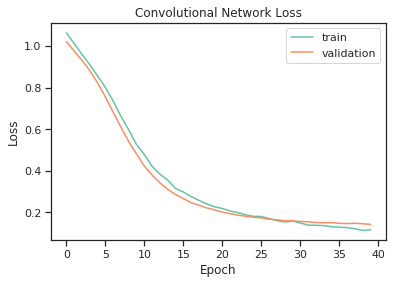

In [17]:
conv_net = model.fit(train_features, train_labels, 
                    epochs=40, batch_size=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(conv_net.history['loss'])
plt.plot(conv_net.history['val_loss'])
plt.title('Convolutional Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

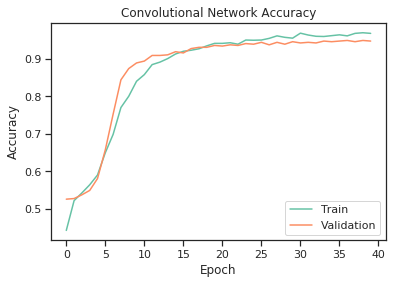

In [18]:
plt.figure()
plt.plot(conv_net.history['categorical_accuracy'])
plt.plot(conv_net.history['val_categorical_accuracy'])
plt.title('Convolutional Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [19]:
conv_net.history['val_categorical_accuracy']

[0.5250836,
 0.52675587,
 0.5367893,
 0.548495,
 0.58026755,
 0.6571906,
 0.75250834,
 0.8444816,
 0.87458193,
 0.8896321,
 0.89464885,
 0.909699,
 0.909699,
 0.91137123,
 0.91973245,
 0.916388,
 0.9280937,
 0.93143815,
 0.93143815,
 0.93645483,
 0.9347826,
 0.9381271,
 0.93645483,
 0.9414716,
 0.9397993,
 0.94481605,
 0.9381271,
 0.94481605,
 0.9397993,
 0.9464883,
 0.9431438,
 0.94481605,
 0.9431438,
 0.9481605,
 0.9464883,
 0.9481605,
 0.9498328,
 0.9464883,
 0.9498328,
 0.9481605]

Confusion matrix:
 [[206  10   0]
 [  6 169   4]
 [  5   8 390]]


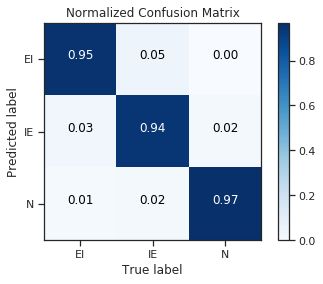

In [20]:
predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks(np.arange(3), ('EI', 'IE', 'N'))
plt.yticks(np.arange(3), ('EI', 'IE', 'N'))
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [21]:
def compute_saliency(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

['IE']


Text(0.5, 1.0, 'Saliency Map For Bases In IE Spice Junction')

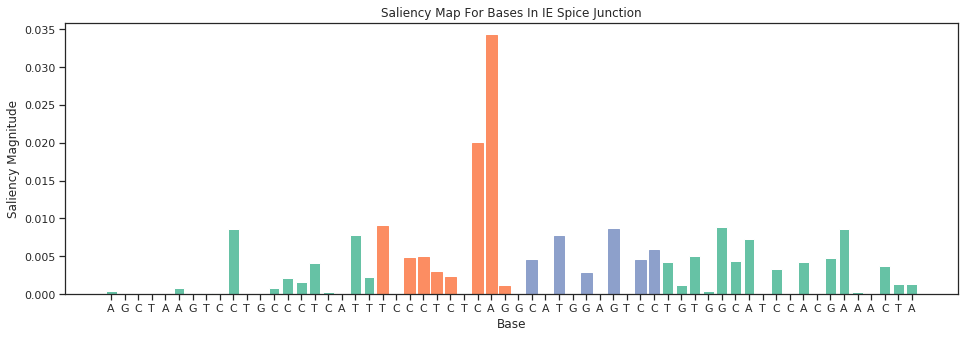

In [30]:
sequence_index = 800
sal = compute_saliency(model, featurized_seq_list[sequence_index])
print(splice_classes[sequence_index])
plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(20,31)]
[barlist[i].set_color('C2') for i in range(31,41)]
plt.xlabel('Base')
plt.ylabel('Saliency Magnitude')
plt.xticks(np.arange(len(sal)), list(splice_data['Sequence'][sequence_index]));
plt.title('Saliency Map For Bases In IE Spice Junction')

['EI']


Text(0.5, 1.0, 'Saliency Map For Bases In EI Spice Junction')

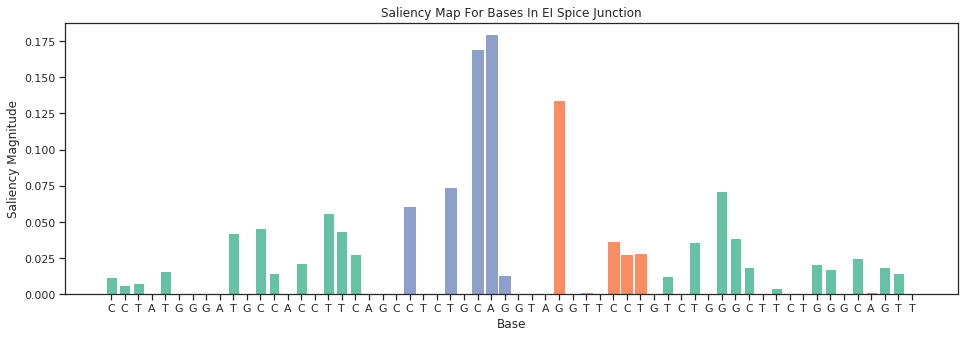

In [28]:
sequence_index = 50
sal = compute_saliency(model, featurized_seq_list[sequence_index])
print(splice_classes[sequence_index])
plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C2') for i in range(20,30)]
[barlist[i].set_color('C1') for i in range(31,41)]
plt.xlabel('Base')
plt.ylabel('Saliency Magnitude')
plt.xticks(np.arange(len(sal)), list(splice_data['Sequence'][sequence_index]));
plt.title('Saliency Map For Bases In EI Spice Junction')

['N']


Text(0.5, 1.0, 'Saliency Map For Bases In IE Spice Junction')

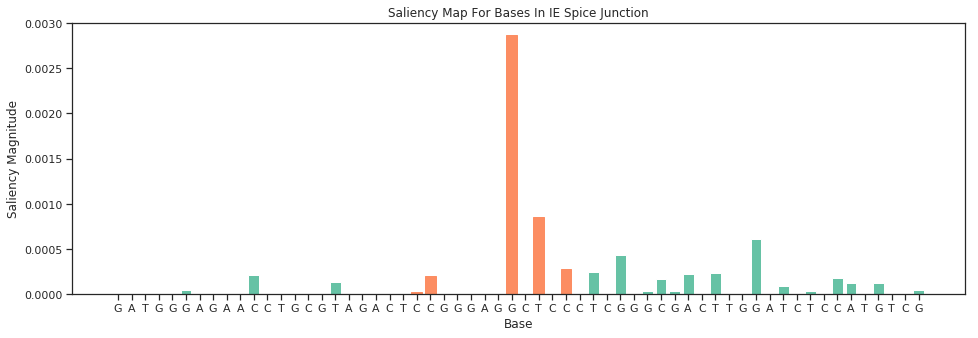

In [26]:
sequence_index = 3100
sal = compute_saliency(model, featurized_seq_list[sequence_index])
print(splice_classes[sequence_index])
plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(20,35)]
plt.xlabel('Base')
plt.ylabel('Saliency Magnitude')
plt.xticks(np.arange(len(sal)), list(splice_data['Sequence'][sequence_index]));
plt.title('Saliency Map For Bases In IE Spice Junction')